Total dataset size:
	num_samples: 1867
	num_features: 1850
	num_classes: 19


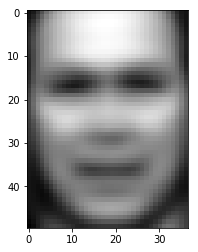

/Users/aashitapatwari/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2168: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)
/Users/aashitapatwari/Documents/csm146/hw4/ps4/code/src/util.py:170: RuntimeWarning: divide by zero encountered in true_divide
  im = x/np.linalg.norm(x)
/Users/aashitapatwari/Documents/csm146/hw4/ps4/code/src/util.py:171: RuntimeWarning: invalid value encountered in multiply
  im = im*(256./np.max(im))
/Users/aashitapatwari/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/aashitapatwari/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/aashitapatwari/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/aas

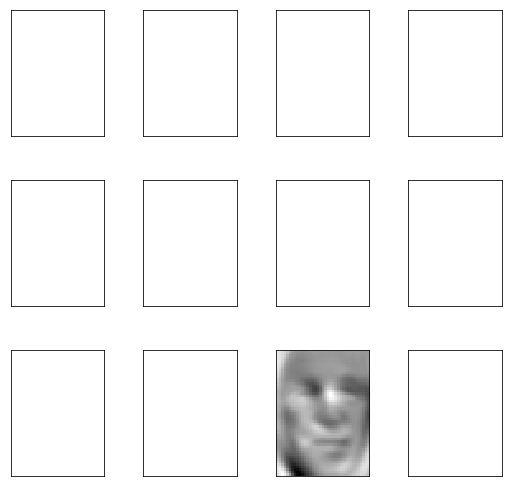

0.775
0.71875
0.625
0.74375
0.5875
0.625
0.59375
0.6125
0.6
0.73125
min score
0.5875
max score
0.775
average score
0.66125
average time
0.23691232204437257
0.6125
0.5875
0.6125
0.60625
0.60625
0.60625
0.58125
0.60625
0.625
0.6125
min score
0.58125
max score
0.625
average
0.6175
average time
0.21698358058929443


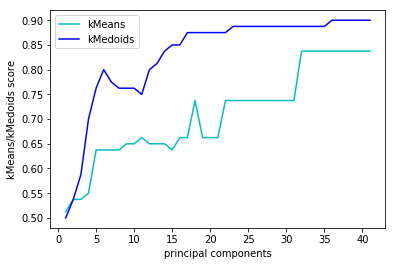

min:
0.285484734869
0
1


TypeError: plot_representative_images() got multiple values for argument 'title'

In [2]:
"""
Author      : Yi-Chieh Wu, Sriram Sankararaman
Description : Famous Faces
"""

# python libraries
import collections

# numpy libraries
import numpy as np

# matplotlib libraries
import matplotlib.pyplot as plt

import time

# libraries specific to project
import util
from util import *
from cluster import *

######################################################################
# helper functions
######################################################################

def build_face_image_points(X, y) :
    """
    Translate images to (labeled) points.
    
    Parameters
    --------------------
        X     -- numpy array of shape (n,d), features (each row is one image)
        y     -- numpy array of shape (n,), targets
    
    Returns
    --------------------
        point -- list of Points, dataset (one point for each image)
    """
    
    n,d = X.shape
    
    images = collections.defaultdict(list) # key = class, val = list of images with this class
    for i in range(n) :
        images[y[i]].append(X[i,:])
    
    points = []
    for face in images :
        count = 0
        for im in images[face] :
            points.append(Point(str(face) + '_' + str(count), face, im))
            count += 1

    return points


def plot_clusters(clusters, title, average) :
    """
    Plot clusters along with average points of each cluster.

    Parameters
    --------------------
        clusters -- ClusterSet, clusters to plot
        title    -- string, plot title
        average  -- method of ClusterSet
                    determines how to calculate average of points in cluster
                    allowable: ClusterSet.centroids, ClusterSet.medoids
    """
    
    plt.figure()
    np.random.seed(20)
    label = 0
    colors = {}
    centroids = average(clusters)
    for c in centroids :
        coord = c.attrs
        plt.plot(coord[0],coord[1], 'ok', markersize=12)
    for cluster in clusters.members :
        label += 1
        colors[label] = np.random.rand(3,)
        for point in cluster.points :
            coord = point.attrs
            plt.plot(coord[0], coord[1], 'o', color=colors[label])
    plt.title(title)
    plt.show()
    


def generate_points_2d(N, seed=1234) :
    """
    Generate toy dataset of 3 clusters each with N points.
    
    Parameters
    --------------------
        N      -- int, number of points to generate per cluster
        seed   -- random seed
    
    Returns
    --------------------
        points -- list of Points, dataset
    """
    np.random.seed(seed)
    
    mu = [[0,0.5], [1,1], [2,0.5]]
    sigma = [[0.1,0.1], [0.25,0.25], [0.15,0.15]]
    
    label = 0
    points = []
    for m,s in zip(mu, sigma) :
        label += 1
        for i in range(N) :
            x = util.random_sample_2d(m, s)
            points.append(Point(str(label)+'_'+str(i), label, x))
    
    return points


######################################################################
# k-means and k-medoids
######################################################################

def random_init(points, k) :
    """
    Randomly select k unique elements from points to be initial cluster centers.
    
    Parameters
    --------------------
        points         -- list of Points, dataset
        k              -- int, number of clusters
    
    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ========== TODO : START ========== ###
    # part 2c: implement (hint: use np.random.choice)
    result = np.random.choice(points, k, replace=False)
    return result
    ### ========== TODO : END ========== ###


def cheat_init(points) :
    """
    Initialize clusters by cheating!
    
    Details
    - Let k be number of unique labels in dataset.
    - Group points into k clusters based on label (i.e. class) information.
    - Return medoid of each cluster as initial centers.
    
    Parameters
    --------------------
        points         -- list of Points, dataset
    
    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ========== TODO : START ========== ###
    # part 2f: implement
    labels = {}
    for point in points:
        if point.label in labels:
            labels[point.label].append(point)
        else:
            labels[point.label] = [point]
    initial_points = []        
    for _,v in labels.items():
        initial_points.append(Cluster(v).medoid())
        
    return initial_points
    ### ========== TODO : END ========== ###

def compute_assignments(clusters, points):
    assignments = {}
    for p in points:
        min_dist, idx = np.Inf, -1
        for i in range(len(clusters)): #for each point see which cluster it is closest too
            dst = p.distance(clusters[i])
            if dst < min_dist:
                min_dist, idx = dst, i
        if idx in assignments:
            assignments[idx].append(p) #add point to assignments dictionary by index 
        else:
            assignments[idx] = [p]
    return assignments

def kMeans(points, k, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.
    
    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        average -- method of ClusterSet
                   determines how to calculate average of points in cluster
                   allowable: ClusterSet.centroids, ClusterSet.medoids
        init    -- string, method of initialization
                   allowable: 
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm
    
    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """
    
    ### ========== TODO : START ========== ###
    # part 2c: implement
    # Hints:
    #   (1) On each iteration, keep track of the new cluster assignments
    #       in a separate data structure. Then use these assignments to create
    #       a new ClusterSet object and update the centroids.
    #   (2) Repeat until the clustering no longer changes.
    #   (3) To plot, use plot_clusters(...).
    cur_centroids = None
    if init == 'random':
        cur_centroids = random_init(points, k)
    else:
        cur_centroids = cheat_init(points)
    
    iters = 0
    prev_clusters = None
    k_clusters = None
    plot_title = 'kMeans'
    
    while True:
        #cluster_list = []
        cur_cluster_set = ClusterSet()
        for _,v in compute_assignments(cur_centroids, points).items():
            cur_cluster_set.add(Cluster(v)) #assigning points to each cluster
    
        #cluster_list = [Cluster(v) for _, v in compute_assignments(cur_centroids, points).items()]
       # cur_cluster_set = ClusterSet(cluster_list)
        iters += 1
        if plot:
            plot_clusters(cur_cluster_set, 'Plot of kMeans {} iteration, {} init'.format(iters, init), ClusterSet.centroids)
        if prev_clusters is not None and cur_cluster_set.equivalent(prev_clusters):
            k_clusters = cur_cluster_set
            break
        else:
            prev_clusters = cur_cluster_set
            cur_centroids = cur_cluster_set.centroids()

    return k_clusters
    ### ========== TODO : END ========== ###


def kMedoids(points, k, init='random', plot=False) :
    """
    Cluster points in k clusters using k-medoids clustering.
    See kMeans(...).
    """
    ### ========== TODO : START ========== ###
    # part 2e: implement
    cur_centroids = None
    if init == 'random':
        cur_centroids = random_init(points, k)
    else:
        cur_centroids = cheat_init(points)
    
    iters = 0
    prev_clusters = None
    k_clusters = None
    plot_title = 'kMedoids'
    
    while True:
        #cluster_list = []
        cur_cluster_set = ClusterSet()
        for _,v in compute_assignments(cur_centroids, points).items():
            cur_cluster_set.add(Cluster(v)) #assigning points to each cluster
        iters += 1
        if plot:
            plot_clusters(cur_cluster_set, 'Plot of kMedoids {} iteration, {} init'.format(iters, init), ClusterSet.medoids)
        if prev_clusters is not None and cur_cluster_set.equivalent(prev_clusters):
            k_clusters = cur_cluster_set
            break
        else:
            prev_clusters = cur_cluster_set
            cur_centroids = cur_cluster_set.medoids()

    return k_clusters
    ### ========== TODO : END ========== ###


######################################################################
# main
######################################################################

def main() :
    ### ========== TODO : START ========== ###
    # part 1: explore LFW data set
    
    X, y = get_lfw_data()
    mean = np.mean(X, axis=0)
    #print(mean)
    #show_image(mean)
    show_image(vec_to_image(mean))
    
    U, mu = PCA(X)
    plot_gallery([vec_to_image(U[:,i]) for i in range(12)])
    
    #plot_title = "1c-"
    #for l in [1,10,50,100,500,1288]:
     #   Z, Ul = apply_PCA_from_Eig(X, U, l, mu)
      #  X_rec = reconstruct_from_PCA(Z, Ul, mu)
       # title = plot_title + str(l)
        #plot_gallery([vec_to_image(X_rec[i]) for i in range(12)], title=title)
        
    
    ### ========== TODO : END ========== ###
    
    
    ### ========== TODO : END ========== ###
    
    
    
    ### ========== TODO : START ========== ###    
    # part 3a: cluster faces
    np.random.seed(1234)
    X1, y1 = util.limit_pics(X, y, [4, 6, 13, 16], 40)
    points = build_face_image_points(X1, y1)
    minScoreMeans = 1000
    maxScoreMeans = -1000
    average = 0
    totalTime = 0
    for i in range(10):
        start = time.time()
        scoreMeans = kMeans(points, 4, init='random').score()
        print(scoreMeans)
        if(i==0):
            minScoreMeans = scoreMeans
            maxScoreMeans = scoreMeans
            average = scoreMeans
            totalTime = time.time() - start
        else:
            if scoreMeans < minScoreMeans:
                minScoreMeans = scoreMeans
            if scoreMeans > maxScoreMeans:
                maxScoreMeans = scoreMeans
            average += scoreMeans
            totalTime += time.time() - start
    print("min score")
    print(minScoreMeans)
    print("max score")
    print(maxScoreMeans)
    print("average score")
    print(average/10)
    print("average time")
    print(totalTime/10)
    
    minScoreMedoids = 1000
    maxScoreMedoids = -1000
    averageM = 0
    totalTime = 0
    for i in range(10):
        start = time.time()
        scoreMedoids = kMedoids(points, 4, init='random').score()
        print(scoreMedoids)
        if(i==0):
            minScoreMedoids = scoreMedoids
            maxScoreMedoids = scoreMedoids
            averageM = scoreMeans
            totalTime = time.time() - start
        else:
            if scoreMedoids < minScoreMedoids:
                minScoreMedoids = scoreMedoids
            if scoreMedoids > maxScoreMedoids:
                maxScoreMedoids = scoreMedoids
            averageM += scoreMedoids
            totalTime += time.time() - start
    print("min score")
    print(minScoreMedoids)
    print("max score")
    print(maxScoreMedoids)
    print("average")
    print(averageM/10)
    print("average time")
    print(totalTime/10)
        
    # part 3b: explore effect of lower-dimensional representations on clustering performance
    np.random.seed(1234)
    scoresMeans = []
    scoresMedoids = []
    l_values = []
    X1, y1 = util.limit_pics(X, y, [4, 13], 40)
    for l in range(1, 42):
        l_values.append(l)
        l+=2
    
    for l in l_values:
        Z, U1 = apply_PCA_from_Eig(X1, U, l, mu)
        X_rec = reconstruct_from_PCA(Z, U1, mu)
        points = build_face_image_points(X_rec, y1)
        
        scoreM = kMeans(points, 2, init='cheat').score()
        scoreM2 = kMedoids(points, 2, init='cheat').score()
        scoresMeans.append(scoreM)
        scoresMedoids.append(scoreM2)        

    plt.plot(l_values, scoresMeans, 'c', label='kMeans')
    plt.plot(l_values, scoresMedoids, 'b', label='kMedoids')
    plt.xlabel('principal components')
    plt.ylabel('kMeans/kMedoids score')
    plt.legend()
    plt.show()
    
    # part 3c: determine ``most discriminative'' and ``least discriminative'' pairs of images
    np.random.seed(1234)
    
    score = 0
    minScore = 1000
    iMin = -1
    iMax = -1
    jMin = -1
    jMax = -1
    maxScore = -1000

    for i in range(0,19):
        for j in range(0,19):
            if i != j:
                X2, y2 = util.limit_pics(X, y, [i, j], 40)
                points = build_face_image_points(X, y)
                score = kMedoids(points,2, init='cheat').score()
                if score < minScore:
                    minScore = score
                    iMin = i
                    jMin = j
                if score > maxScore:
                    maxScore = score
                    iMax = i
                    jMax = j
                
    print("min:")
    print(minScore)
    print(iMin)
    print(jMin)
    plot_representative_images(X, y, iMin, jMin, title="min")
    print("max:")
    print(maxScore)
    print(iMax)
    print(jMax)
    plot_representative_images(X, y, iMax, jMax, title="min")
        
    
    ### ========== TODO : END ========== ###


if __name__ == "__main__" :
    main()
